In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score



In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip"

In [ ]:
# look at notebook data .tif
directory = '/content/input/Kather_texture_2016_image_tiles_5000'
for dirname, _, filenames in os.walk(directory):
    print(dirname , _, filenames[:2])

/content/input/Kather_texture_2016_image_tiles_5000 ['Kather_texture_2016_image_tiles_5000'] []
/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000 ['06_MUCOSA', '07_ADIPOSE', '04_LYMPHO', '03_COMPLEX', '01_TUMOR', '08_EMPTY', '05_DEBRIS', '02_STROMA'] []
/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/06_MUCOSA [] ['233F_CRC-Prim-HE-08_022.tif_Row_151_Col_1801.tif', '11684_CRC-Prim-HE-03_006.tif_Row_1501_Col_1201.tif']
/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/07_ADIPOSE [] ['12002_CRC-Prim-HE-05_032.tif_Row_1351_Col_1801.tif', '12949_CRC-Prim-HE-03_012.tif_Row_2701_Col_1651.tif']
/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/04_LYMPHO [] ['13778_CRC-Prim-HE-09_013.tif_Row_301_Col_1.tif', '17CDB_CRC-Prim-HE-01_004.tif_Row_601_Col_151.tif']
/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_til

In [ ]:
CLASSES_DIR = os.path.join(directory, '/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000')
classes = os.listdir(CLASSES_DIR)
classes
print(classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['06_MUCOSA', '07_ADIPOSE', '04_LYMPHO', '03_COMPLEX', '01_TUMOR', '08_EMPTY', '05_DEBRIS', '02_STROMA']


In [ ]:
tissues_view = []
for label in classes:
    num_items = len(os.listdir(os.path.join(CLASSES_DIR,label)))
    print(label + '\t' + str(num_items))
    tissues_view.append(random.choice(np.arange(num_items)))

06_MUCOSA	625
07_ADIPOSE	625
04_LYMPHO	625
03_COMPLEX	625
01_TUMOR	625
08_EMPTY	625
05_DEBRIS	625
02_STROMA	625


In [ ]:
imgs = []
for idx, label in enumerate(classes):
    show_idx = tissues_view[idx]
    file_name = os.listdir(os.path.join(CLASSES_DIR,label))[show_idx] 
    print(file_name)
    imgs.append(Image.open(os.path.join(CLASSES_DIR,label,file_name)))

17841_CRC-Prim-HE-07_001.tif_Row_1_Col_2551.tif
10808_CRC-Prim-HE-05_032.tif_Row_151_Col_4501.tif
1665E_CRC-Prim-HE-01_013.tif_Row_1_Col_1.tif
42D8_CRC-Prim-HE-05_020.tif_Row_1_Col_1.tif
11BD1_CRC-Prim-HE-02_025.tif_Row_1_Col_751.tif
1240E_CRC-Prim-HE-06_005.tif_Row_4651_Col_4951.tif
771C_CRC-Prim-HE-08_021.tif_Row_1651_Col_151.tif
13843_CRC-Prim-HE-04_013.tif_Row_1651_Col_1.tif


In [ ]:
import matplotlib.pyplot as plt

def display_pil_images(
    images, 
    labels,
    columns=4, width=40, height=16, max_images=15, 
    label_wrap_length=100, label_font_size=16):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
        
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        plt.title(labels[i], fontsize=label_font_size); 
        
##display_pil_images(imgs, classes)

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
## viene creata un associazione tramite array paralleli per associare ogni path dell'immagine la sua classe di appartenenza
## es MUCOSA --> Mucosa/img01 .... etc 625*8 = 5000 print
imgs_paths, labels = [], []
for label in classes:
    file_names = os.listdir(os.path.join(CLASSES_DIR,label))
    for file_name in file_names:
        imgs_paths.append(os.path.join(CLASSES_DIR,label,file_name))
        labels.append(label)


In [ ]:
##il DataFrame visualizza i dati in maniera tabulare e bidimensionale
## esempio  d = {'col1': [1, 2], 'col2': [3, 4]}
##   col1  col2
## 0     1     3
## 1     2     4


df = pd.DataFrame(data={'img_path': imgs_paths, 'label': labels})

##sostituisce le label della colonna 2 con il valore associato alla classe di appartenenza
## es 0         01_TUMOR
##    1         01_TUMOR
##    2         01_TUMOR
##    3         01_TUMOR
##    4         01_TUMOR
## DOPO apply lambda ---------
##    0       0
##    1       0
##    2       0
##    3       0
##    4       0
label_num = {}
for idx, item in enumerate(np.unique(df.label)):
    label_num[item] = idx 
df['label_num'] = df['label'].apply(lambda x: label_num[x])
print(df.shape)
print(df.to_records(index=False))

(5000, 3)
[('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/06_MUCOSA/233F_CRC-Prim-HE-08_022.tif_Row_151_Col_1801.tif', '06_MUCOSA', 5)
 ('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/06_MUCOSA/11684_CRC-Prim-HE-03_006.tif_Row_1501_Col_1201.tif', '06_MUCOSA', 5)
 ('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/06_MUCOSA/15A06_CRC-Prim-HE-05.tif_Row_751_Col_301.tif', '06_MUCOSA', 5)
 ...
 ('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/02_STROMA/10828_CRC-Prim-HE-04.tif_Row_301_Col_3451.tif', '02_STROMA', 1)
 ('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/02_STROMA/12CA9_CRC-Prim-HE-09_023.tif_Row_1_Col_1051.tif', '02_STROMA', 1)
 ('/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/02_STROMA/13117_CRC-Prim-HE-10_019.tif_Row_601_Col_601

In [ ]:
class HistologyMnistDS(D.Dataset):
    def __init__(self, df, transforms, mode='train'):

        self.records = df.to_records(index=False)
        self.transforms = transforms
        self.mode = mode
        self.len = df.shape[0]
    
    @staticmethod
    def _load_image_pil(path):
        return Image.open(path)
        
    def __getitem__(self, index):
        path = self.records[index].img_path

        img = self._load_image_pil(path)
        
        if self.transforms:
            img = self.transforms(img)

        if self.mode in ['train', 'val', 'test']:
            return img, torch.from_numpy(np.array(self.records[index].label_num))
        else:
            return img

    def __len__(self):
        return self.len

In [ ]:
## link utile https://medium.com/mlearning-ai/understanding-torchvision-functionalities-for-pytorch-part-2-transforms-886b60d5c23a
##transforms sono semplici funzioni di trasformazione dell'immagine che possono 
##essere eseguite in sequenza subito dopo il dataset caricamento di ( immagini )
## Nel codice, stiamo definendo le trasformazioni che dobbiamo fare sulle immagini 
## Le seguenti 3 trasformazioni vengono eseguite nell'ordine in cui sono menzionate
## Resize (ridimensione l'immagine 224x224)
## ToTensor (convertire tutto in un Image Tensor)
## Normalize (La normalizzazione aiuta a ottenere dati all'interno di un intervallo
## e riduce l'asimmetria riuscendo ad imparare più velocemente e meglio. I valori 0.485 ecc sono fissi vedi link sopra primo commento)
## spiegazione train_test_split preso dal seguente link:https://www.educative.io/answers/what-is-the-traintestsplit-function-in-sklearn
## La train_test_splitfunzione accetta i seguenti valori di parametro:
##*arrays: Questi sono gli array o le matrici che devono essere divisi.
##test_size: Questa è la dimensione del sottoinsieme di test. Se questo parametro è un int, rappresenta il numero di valori che devono essere aggiunti al sottoinsieme di test. Se questo parametro è un float, rappresenta la proporzione del set di dati che deve essere aggiunto al sottoinsieme di test.
##train_size: Questa è la dimensione del sottoinsieme del treno. Simile al test_sizeparametro, il train_sizeparametro può essere a floato an int.
##random_state: Questo valore di parametro controlla come i dati vengono mescolati prima di essere divisi.
##stratify: Questa classe di valore del parametro etichetta per consentire la suddivisione dei dati in modo stratificato. 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


skf =StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df, tmp_df = train_test_split(df, test_size=0.2, train_size=0.8, stratify=df['label'])
valid_df, test_df = train_test_split(tmp_df, test_size=0.80, train_size=0.20, stratify=tmp_df['label'])
##train_df, tmp_df = train_test_split(df,
##                                     test_size=0.2,  
##                                      random_state=2000,
##                                      stratify=df['label'])

##valid_df, test_df = train_test_split(tmp_df,
##                                     test_size=0.8,  
##                                      random_state=2000,
##                                      stratify=tmp_df['label'])

print("Train DF shape:", train_df.shape)
print("Valid DF shape:", valid_df.shape)
print("Test DF shape:", test_df.shape)



Train DF shape: (4000, 3)
Valid DF shape: (200, 3)
Test DF shape: (800, 3)


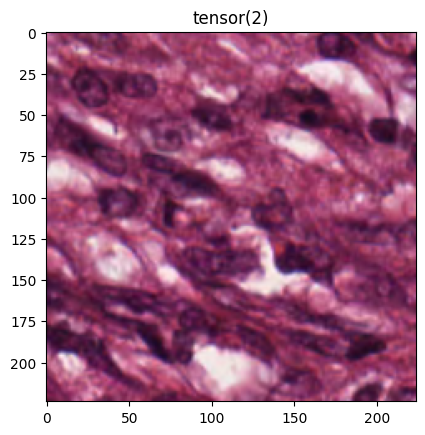

In [ ]:
ds_train = HistologyMnistDS(train_df, train_transforms)
ds_val = HistologyMnistDS(valid_df, val_transforms, mode='val')
ds_test = HistologyMnistDS(test_df, val_transforms, mode='test')

##1. Set di dati: il primo parametro nella DataLoaderclasse è il file dataset. Qui è da dove carichiamo i dati.
##2. Batching dei dati: batch_size si riferisce al numero di campioni di addestramento utilizzati in un'iterazione. Di solito dividiamo i nostri dati in set di addestramento e test e potremmo avere lotti di dimensioni diverse per ciascuno.
##3. shuffle: shuffle è un altro argomento passato alla DataLoaderclasse. L'argomento accetta un valore booleano (vero/falso). Se shuffle è impostato su True, tutti i campioni vengono mescolati e caricati in batch. In caso contrario, vengono inviati uno per uno senza alcun rimescolamento.
##4. Consentire l'elaborazione multipla: poiché il deep learning implica l'addestramento di modelli con molti dati, l'esecuzione di singoli processi finisce per richiedere molto tempo. In PyTorch, puoi aumentare il numero di processi in esecuzione contemporaneamente consentendo il multiprocessing con l'argomento num_workers. Questo dipende anche dalla dimensione del batch, ma non imposterei num_workerslo stesso numero perché ogni lavoratore carica un singolo batch e lo restituisce solo quando è pronto.
##num_workers=0significa che è il processo principale che esegue il caricamento dei dati quando necessario.
##num_workers=1significa che hai un solo lavoratore, quindi potrebbe essere lento.

## ho impostato num_workers a 1 perchè 4 o 2 dava problemi.
train_loader = D.DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=1)
val_loader = D.DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=1)
test_loader = D.DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=1)


X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
plt.title(y_batch[0]);

In [ ]:

import copy 

checkpoints_dir = '/working/'

history_train_loss = []   ## il training loss rapprensenta quanto bene il modello si sta adattando ai dati di addestramento
history_val_loss = []   ## il val loss indica quanto bene il modello si adatta ai nuovi dati



## funzione che 
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())  ## si crea una copia senza riferimento del  modello
       
    best_loss = 10e10 #  init del massimo della perdita di apprendimento 
    best_acc_score = 0.0 #init dell' accurancy score
    epoch_loss = 0.0
    for epoch in range(num_epochs): # inizia a scorrere il numero di epoche
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True) #stampo le epoca corrente

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step(epoch_loss)
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0. ## valori che vengono calcolati a runtime ad ogni epoca di perdita 
            running_acc = 0. ## valori che vengono calcolati a runtime ad ogni epoca di accuratezza

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)


                #In PyTorch, per ogni mini-batch durante la fase di addestramento , 
                #in genere vogliamo impostare esplicitamente i gradienti su zero prima di iniziare a eseguire
                # la backpropragation (ovvero, aggiornare i pesi e i bias ) perché PyTorch accumula i gradienti nei successivi passaggi all'indietro. 
                #Questo comportamento di accumulo è utile durante l'addestramento degli RNN o quando si desidera calcolare il gradiente della perdita 
                #sommato su più mini-batch . Quindi, l'azione predefinita è stata impostata per accumulare (cioè sommare) 
                #i gradienti ad ogni chiamata.loss.backward()


                optimizer.zero_grad()

                # forward and backward
                ## BAKCWARD PROPAGATION: 
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader) 
            epoch_acc = running_acc / len(dataloader)  # Calcolo dell'accuratezza  accurancy = Number of correct predictions / Total number of predictions

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)


            if phase == 'train':
                history_train_loss.append(epoch_loss)
            else:
                history_val_loss.append(epoch_loss)
            
            if phase == 'val':
                def save_checkpoint(name):
                    checkpoint = {
                        'state_dict': best_model_wts
                    }

                    model_file_name = name + '.pth'

                    model_file = checkpoints_dir + model_file_name

                    if not os.path.exists(checkpoints_dir):
                        os.mkdir(checkpoints_dir)

                    # saving best weights of model
                    torch.save(checkpoint, model_file)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving model for best loss")
                    save_checkpoint('best_model')
                
                if epoch_acc > best_acc_score:
                    best_acc_score = epoch_acc
                    
                print('Best_loss: {:.4f}'.format(best_loss))
                print('Best_acc_score: {:.4f}'.format(best_acc_score))

    return model

         

In [ ]:
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.5 MB/s eta 0:00:00


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = models.resnet34(pretrained=False)

model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)# prima era deit_base_patch16_224

#for param in model.parameters(): 
  #param.requires_grad = False 

n_inputs = model.head.in_features

model.head = nn.Sequential(
    nn.Linear(n_inputs, 512), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes)))

##model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

train_model(model, loss, optimizer, scheduler, num_epochs=15)# impostare a 15




Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


  0%|          | 0.00/21.9M [00:00<?, ?B/s]

Epoch 0/14:


100%|██████████| 63/63 [00:40<00:00,  1.57it/s]

train Loss: 0.9295 Acc: 0.6133



100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

val Loss: 0.8106 Acc: 0.7070
Saving model for best loss
Best_loss: 0.8106
Best_acc_score: 0.7070
Epoch 1/14:



100%|██████████| 63/63 [00:18<00:00,  3.42it/s]

train Loss: 0.5640 Acc: 0.7889



100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

val Loss: 0.6322 Acc: 0.7891
Saving model for best loss
Best_loss: 0.6322
Best_acc_score: 0.7891
Epoch 2/14:



100%|██████████| 63/63 [00:17<00:00,  3.50it/s]

train Loss: 0.4609 Acc: 0.8328



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

val Loss: 0.5365 Acc: 0.8125
Saving model for best loss
Best_loss: 0.5365
Best_acc_score: 0.8125
Epoch 3/14:



100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

train Loss: 0.4483 Acc: 0.8375



100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

val Loss: 0.3953 Acc: 0.8711
Saving model for best loss
Best_loss: 0.3953
Best_acc_score: 0.8711
Epoch 4/14:



100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


train Loss: 0.3678 Acc: 0.8695


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

val Loss: 0.5364 Acc: 0.8125
Best_loss: 0.3953
Best_acc_score: 0.8711
Epoch 5/14:



100%|██████████| 63/63 [00:17<00:00,  3.56it/s]

train Loss: 0.3301 Acc: 0.8829



100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

val Loss: 0.6670 Acc: 0.8281
Best_loss: 0.3953
Best_acc_score: 0.8711
Epoch 6/14:


Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 63/63 [00:17<00:00,  3.65it/s]

train Loss: 0.2244 Acc: 0.9253



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

val Loss: 0.3967 Acc: 0.8633
Best_loss: 0.3953
Best_acc_score: 0.8711
Epoch 7/14:



100%|██████████| 63/63 [00:17<00:00,  3.63it/s]

train Loss: 0.1547 Acc: 0.9469



100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

val Loss: 0.3895 Acc: 0.8789
Saving model for best loss
Best_loss: 0.3895
Best_acc_score: 0.8789
Epoch 8/14:



100%|██████████| 63/63 [00:17<00:00,  3.60it/s]

train Loss: 0.1328 Acc: 0.9546



100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

val Loss: 0.3759 Acc: 0.9062
Saving model for best loss
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 9/14:



100%|██████████| 63/63 [00:17<00:00,  3.64it/s]

train Loss: 0.1105 Acc: 0.9593



100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

val Loss: 0.4290 Acc: 0.8633
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 10/14:



100%|██████████| 63/63 [00:17<00:00,  3.63it/s]

train Loss: 0.0892 Acc: 0.9730



100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

val Loss: 0.4747 Acc: 0.8320
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 11/14:



100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


train Loss: 0.0679 Acc: 0.9774


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

val Loss: 0.4858 Acc: 0.8750
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 12/14:


Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 63/63 [00:17<00:00,  3.67it/s]

train Loss: 0.0429 Acc: 0.9893



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

val Loss: 0.3873 Acc: 0.8672
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 13/14:



100%|██████████| 63/63 [00:17<00:00,  3.70it/s]

train Loss: 0.0378 Acc: 0.9901



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

val Loss: 0.3858 Acc: 0.8633
Best_loss: 0.3759
Best_acc_score: 0.9062
Epoch 14/14:



100%|██████████| 63/63 [00:17<00:00,  3.68it/s]

train Loss: 0.0349 Acc: 0.9923



100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

val Loss: 0.3760 Acc: 0.8633
Best_loss: 0.3759
Best_acc_score: 0.9062


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

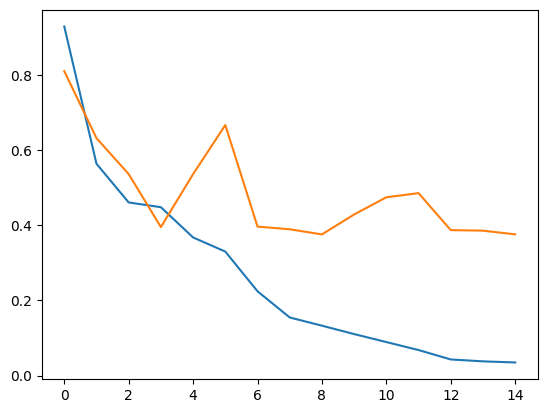

In [ ]:
##9---> NUMERO EPOCHE DA CREARE VARIABILE GLOBALE
x = np.arange(15)#impostare a 15
plt.plot(x, history_train_loss)
plt.plot(x, history_val_loss)

In [ ]:
filename = "best_model.pth"

model.load_state_dict(torch.load(os.path.join(checkpoints_dir, filename))['state_dict'])
    
model.eval()

y_preds = []
all_labels = []
y_preds_onehot = np.array([])
all_labels_onehot = np.array([])

for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)

    y_preds.append(preds.argmax(dim=1).data.cpu().numpy())
    all_labels.append(labels.cpu().numpy())
    labels_onehot = np.zeros((labels.cpu().numpy().size, labels.cpu().numpy().max() + 1))
    labels_onehot[np.arange(labels.cpu().numpy().size), labels.cpu().numpy()] = 1
    if(len(labels) == 64):
      if(np.any(y_preds_onehot)):
        y_preds_onehot = np.concatenate([y_preds_onehot, preds.cpu().numpy()], axis = -1)
        all_labels_onehot = np.concatenate([all_labels_onehot, labels_onehot], axis = -1)
      else:
        y_preds_onehot = preds.cpu().numpy()
        all_labels_onehot = labels_onehot
   
y_preds = np.concatenate(y_preds)
all_labels = np.concatenate(all_labels)
#y_preds_onehot = np.concatenate(y_preds_onehot)
#all_labels_onehot = np.concatenate(all_labels_onehot)

100%|██████████| 13/13 [00:02<00:00,  4.81it/s]


In [ ]:
inputs, labels = next(iter(test_loader))

for img, label, pred in zip(inputs, labels, y_preds):
    title = f"True label: {label}\nPredicted label: {pred}"
    ##show_input(img, title=title)



800
800


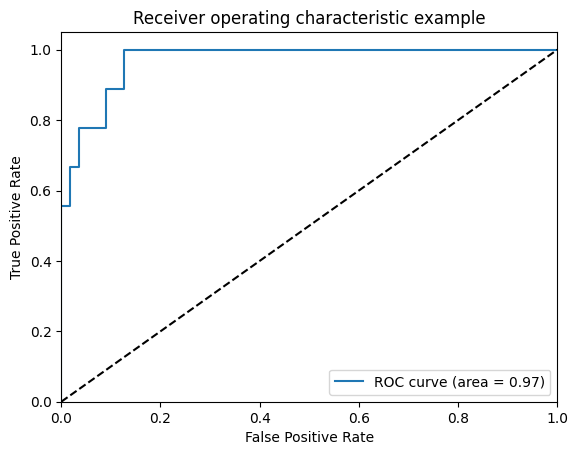

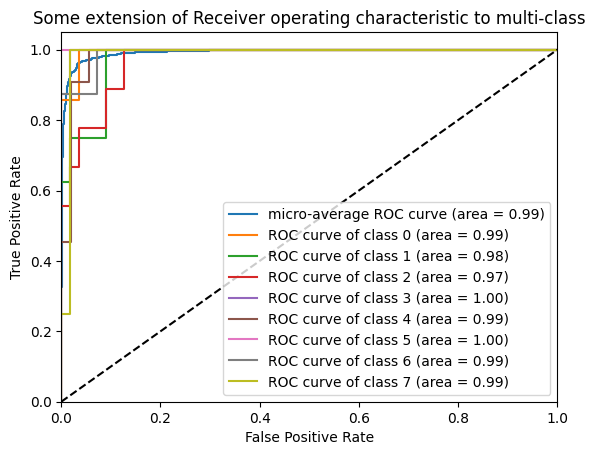

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
fpr = dict()
tpr = dict()
roc_auc = dict()
print(len(all_labels))
print(len(y_preds))
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], y_preds_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_onehot.ravel(), y_preds_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[92  2  5  1  0  0  0  0]
 [ 0 87  8  0  3  0  2  0]
 [ 2  3 89  4  2  0  0  0]
 [ 4  0  4 91  0  1  0  0]
 [ 0 11  0  0 81  5  3  0]
 [ 1  0  0  0  0 99  0  0]
 [ 0  1  0  0  0  0 94  5]
 [ 0  0  0  0  0  0  1 99]]
              precision    recall  f1-score   support

    01_TUMOR       0.93      0.92      0.92       100
   02_STROMA       0.84      0.87      0.85       100
  03_COMPLEX       0.84      0.89      0.86       100
   04_LYMPHO       0.95      0.91      0.93       100
   05_DEBRIS       0.94      0.81      0.87       100
   06_MUCOSA       0.94      0.99      0.97       100
  07_ADIPOSE       0.94      0.94      0.94       100
    08_EMPTY       0.95      0.99      0.97       100

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.91       800
weighted avg       0.92      0.92      0.91       800



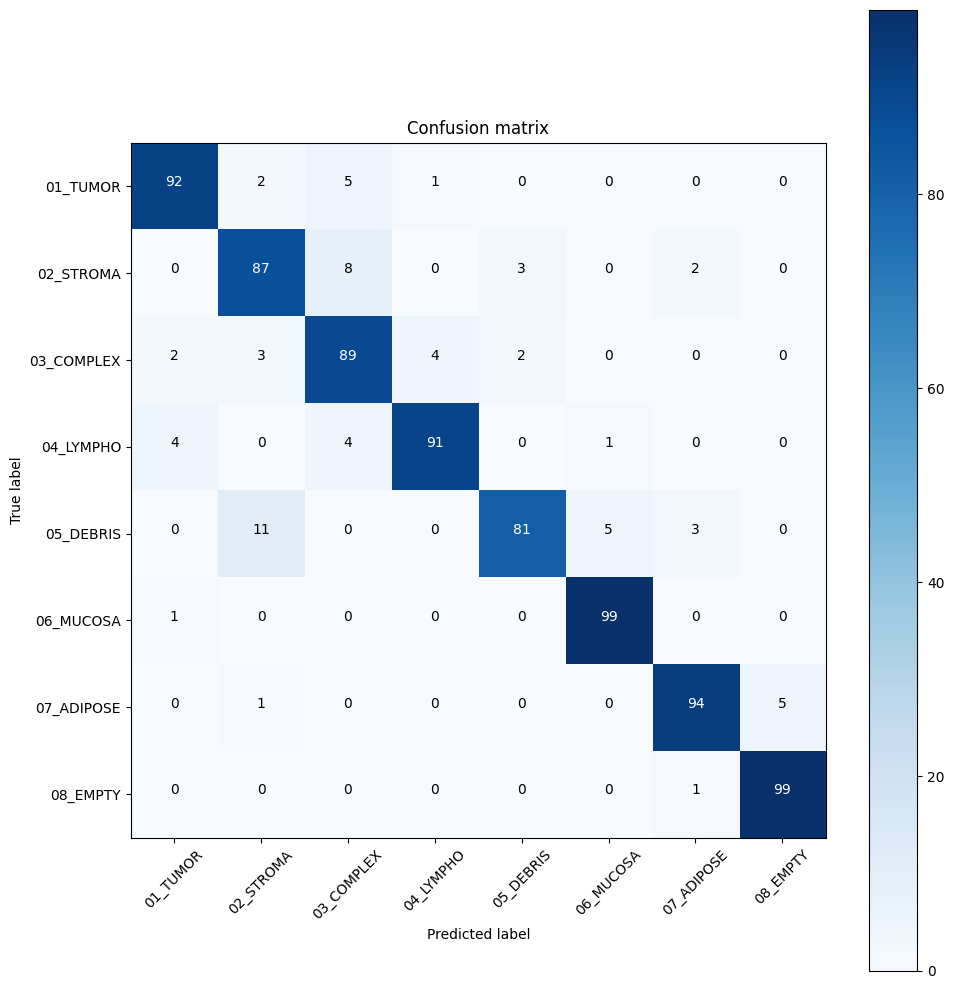

In [ ]:
cm = confusion_matrix(test_df.label_num.values, y_preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, label_num)
print(classification_report(test_df.label_num.values, 
                            y_preds, 
                            target_names=list(label_num.keys())))

In [ ]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,\
    preprocess_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=f1a85e99c067bb13acc27aaaa47b11c235ae0fcca203e2a84cd5ecd92b597649
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


(224, 224, 3)
torch.Size([1, 192, 14, 14])
torch.Size([1, 192, 14, 14])


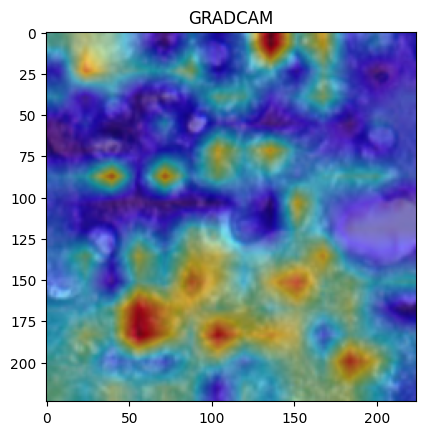

In [ ]:
import cv2


def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    print(result.shape)
    return result
imgGRAD = '/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif'
batchSize = 1#14 ##96 with mobilenet
loader_opts = {'batch_size': batchSize, 'num_workers': 0, 'pin_memory': False}
#model.load_state_dict(torch.load(os.path.join('/working/best_model.pth'), strict = False))
loaded_weights = torch.load(os.path.join('/working/best_model.pth'))
##model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)# prima era deit_base_patch16_224
##model.head = nn.Sequential(
  ##  nn.Linear(n_inputs, 512), 
    ##nn.ReLU(),
    ##nn.Dropout(0.3),
    ##nn.Linear(512, len(classes)))
model.eval()
model.load_state_dict(loaded_weights, strict=False)
model.blocks[-1].norm1.requires_grad = True
target_layers = [model.blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform = reshape_transform)
#targets = [ClassifierOutputTarget(1)]
targets = None
test_loader = D.DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=1)

rgb_img = cv2.imread(imgGRAD, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
#rgb_img = np.transpose(rgb_img, (2, 0, 1))
rgb_img = torch.from_numpy(rgb_img)
#rgb_img = rgb_img.transpose(1, 2).transpose(0, 1)
print(rgb_img.cpu().numpy().shape)
#print(rgb_img.shape)
input_tensor = preprocess_image(rgb_img.cpu().numpy(), mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
#print(input_tensor.shape)


grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]
#rgb_show = np.transpose(rgb_img, (2, 0, 1))
visualization = show_cam_on_image(rgb_img.cpu().numpy(), grayscale_cam, use_rgb=True)

plt.figure(1)
plt.title('GRADCAM')
plt.imshow(visualization)

In [ ]:
import cv2
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
imgGRAD = '/content/input/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif'
batchSize = 1#14 ##96 with mobilenet
loader_opts = {'batch_size': batchSize, 'num_workers': 0, 'pin_memory': False}
##model.load_state_dict(torch.load(os.path.join('/working/best_model.pth'), strict = False))
loaded_weights = torch.load(os.path.join('/working/best_model.pth'))
model.load_state_dict(loaded_weights, strict=False)
target_layers = [model.blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True,reshape_transform = reshape_transform)
targets = [ClassifierOutputTarget(1)]
test_loader = D.DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=1)
i = 0
for inputs, labels in tqdm(test_loader):
    #inputs = inputs.reshape((inputs.shape[0]*inputs.shape[1], inputs.shape[2], inputs.shape[3], inputs.shape[4]))
    inputs = inputs.type(torch.FloatTensor).to(device=device)
    #inputs = inputs.squeeze(0)
    y = model(inputs)
    rgb_img = inputs.squeeze(0)
    print(rgb_img.shape)
    rgb_img = rgb_img.transpose(0, 1).transpose(1, 2)
    print(rgb_img.shape)
    #rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = rgb_img / 255
    input_tensor = preprocess_image(rgb_img.cpu().numpy(), mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
    preds = y.argmax(dim=1)# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor)
    #grayscale_cam = cam(input_tensor=inputs)     # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    #visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    visualization = show_cam_on_image(inputs.squeeze(0).permute(1, 2, 0).detach().cpu().numpy(), grayscale_cam, use_rgb=True)
    plt.figure(i)
    plt.title(str(preds[0].item()))
    i += 1
    plt.imshow(visualization)

  0%|          | 0/800 [00:00<?, ?it/s]

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


Exception: ignored